# GW170817: Posterior plot comparison

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import bilby
import pandas as pd
import numpy as np
import seaborn as sns
from bilby.gw.result import CBCResult
import matplotlib.lines as mlines
from kde_contour import Bounded_1d_kde, kdeplot_2d_clevels

### Waveforms: TaylorF2Ecck, TaylorF2Ecc 3.5PN (with aligned spin), TaylorF2Ecc 3.5PN (with aligned spin, LNB result), IMRPhenomPv2NRT (GWTC,LVK result)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import bilby
import pandas as pd
import numpy as np
import seaborn as sns
from bilby.gw.result import CBCResult
import matplotlib.lines as mlines
from kde_contour import Bounded_1d_kde, kdeplot_2d_clevels

rng = np.random.default_rng(12345)
sns.set_theme(palette='colorblind', font_scale=1.5)
nsamples = 4114

result1 = bilby.result.read_in_result("../result_files/ecck.hdf5").posterior
df1 = result1.sample(nsamples, random_state=rng)
df1["templates"] = np.full(len(df1), "Ecck 3PN")
df1["chirp_mass"] = df1["chirp_mass"]
df1["eccentricity"] = df1["eccentricity"]

result3 = bilby.result.read_in_result("../result_files/ecc3p5PNspin.hdf5").posterior
result_ecc3p5spin = result3.sample(nsamples, random_state=rng)
result_ecc3p5spin["templates"] = np.full(len(result_ecc3p5spin), "Ecc3.5PN spin")
result_ecc3p5spin["chirp_mass"] = result_ecc3p5spin["chirp_mass"]
result_ecc3p5spin["eccentricity"] = result_ecc3p5spin["eccentricity"]

f = h5py.File('../result_files/GW170817_GWTC-1.hdf5', 'r')
events = f['IMRPhenomPv2NRT_lowSpin_posterior']
m10 = np.array(events['m1_detector_frame_Msun'])
m20 = np.array(events['m2_detector_frame_Msun'])
chirp_mass0 = ( (m10*m20)**(3/5) )/( (m10+m20)**(1/5) )
mass_ratio0 = m20/m10
result_pv2nrt = pd.DataFrame({'chirp_mass': chirp_mass0, 'mass_ratio': mass_ratio0, 'templates': 'Pv2NRT'})
result_pv2nrt = result_pv2nrt.sample(nsamples, random_state=rng)
result_pv2nrt["chirp_mass"] = result_pv2nrt["chirp_mass"]
result_pv2nrt["eccentricity"] = np.full(len(result_pv2nrt), None)

result5 = h5py.File("../result_files/tf2_e_170817v2.hdf", "r")
m1_src = np.array(result5['samples']['srcmass1'])
m2_src = np.array(result5['samples']['srcmass2'])
idx = m1_src < m2_src
m1_src[idx], m2_src[idx] = m2_src[idx], m1_src[idx]
dl = np.array(result5['samples']['distance'])
# import astropy, convert dl to z, and convert mass to detector frame
from astropy.cosmology import Planck18
from astropy import units as u
# make a spline 
from scipy.interpolate import interp1d
z = np.linspace(0, 2, 1000)
dl_ = Planck18.luminosity_distance(z)
f = interp1d(dl_, z)
z = f(dl)
m15 = m1_src*(1+z)
m25 = m2_src*(1+z)
chirp_mass5 = ( (m15*m25)**(3/5) )/( (m15+m25)**(1/5) )
mass_ratio5 = m25/m15
e05 = np.array(result5['samples']['eccentricity'])
result_lnb = pd.DataFrame({'chirp_mass': chirp_mass5, 'mass_ratio': mass_ratio5, 'eccentricity': e05, 'templates': 'LNB'})
result_lnb = result_lnb.sample(2400, random_state=rng)
result_lnb["chirp_mass"] = result_lnb["chirp_mass"]
result_lnb["eccentricity"] = result_lnb["eccentricity"]

result = pd.concat([df1, result_ecc3p5spin, result_lnb, result_pv2nrt], ignore_index=True)

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_36852/1679013965.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([df1, result_ecc3p5spin, result_lnb, result_pv2nrt], ignore_index=True)


In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    'backend': 'Agg',
    'savefig.dpi': 300,
    'grid.alpha': 0.5,
    'path.simplify': True,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    'mathtext.fontset': 'custom',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'lines.markeredgewidth': 1,
    'legend.numpoints': 1,
    'legend.frameon': False,
    'legend.handletextpad': 0.3
})

lw = 1

def kdeplot2d(x, y, rng=12345, **kws):
    kws.pop('label', None)
    kdeplot_2d_clevels(xs=x, ys=y, auto_bound=True, linewidths=lw, rng=rng, **kws)

vars = ['chirp_mass', 'mass_ratio', 'eccentricity']
g = sns.PairGrid(data=result,
                 vars=vars,
                 corner=True, 
                 hue="templates",
                 palette=['C0', 'C3', 'C4', 'C5'],
                 diag_sharey=False,
                 layout_pad=0.,
                 height=1.5,
                )
g.map_lower(kdeplot2d, levels=[0.864,0.393])
# nsamples = 2400, time = 20.9s

In [17]:
def kdeplot1d(x, **kws):
    #  define colors for plt
    if kws['label']=='Ecck 3PN':
        color = 'C0'
    elif kws['label']=='Ecc3.5PN spin':
        color = 'C3'
    elif kws['label']=='Pv2NRT':
        color = 'C5'
    elif kws['label']=='LNB':
        color = 'C4'
    else:
        raise ValueError('Invalid template')

    if np.all(x.isna()):
        return
    for key in ['label', 'hue_order', 'color', 'ax']:
        kws.pop(key, None)
    df = pd.DataFrame({'x': x, 'y': Bounded_1d_kde(x, xlow=min(x), xhigh=max(x), **kws)(x)})
    df = df.sort_values(['x'])
    plt.fill_between(df['x'], df['y'], np.zeros(len(x)), alpha=0.1, color=color)
    plt.plot(df['x'], df['y'], lw=lw, color=color)
    plt.xlim(df['x'].min(), df['x'].max())
    current_ymax = plt.ylim()[1]
    if current_ymax > df['y'].max()*1.05:
        plt.ylim(0,current_ymax)
    else:
        current_ymax = df['y'].max()*1.05
        plt.ylim(0,df['y'].max()*1.05)
    print(current_ymax)

g.map_diag(kdeplot1d)

7061.0975386602
7061.0975386602
7061.0975386602
7061.0975386602
13.782033426836543
13.782033426836543
13.782033426836543
13.782033426836543
224.45534806041732
285.48447498138336
285.48447498138336


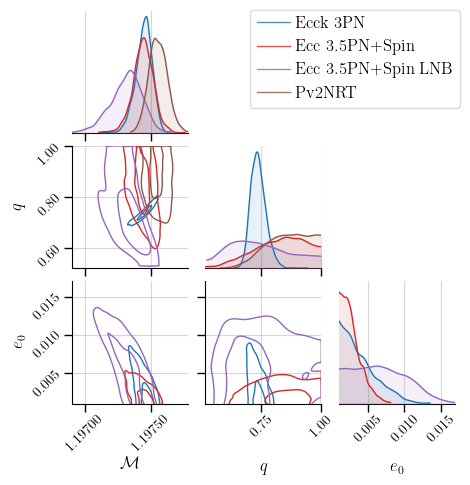

In [18]:
g.axes[2, 2].tick_params(axis='x', rotation=45, pad=1)
g.axes[2, 1].tick_params(axis='x', rotation=45, pad=1)
g.axes[2, 0].tick_params(axis='x', rotation=45, pad=1)
g.axes[2, 0].tick_params(axis='y', rotation=45, pad=1)
g.axes[1, 0].tick_params(axis='y', rotation=45, pad=1)

g.axes[2, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.5f' % x))
g.axes[2, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.2f' % x))
g.axes[2, 2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.3f' % x))
g.axes[2, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.3f' % x))
g.axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%.2f' % x))  

g.axes[2,0].set_xlabel(r'$\mathcal{M}$', labelpad=2, fontsize=12)
g.axes[1,0].set_ylabel(r'$q$', labelpad=8, fontsize=12)
g.axes[2,1].set_xlabel(r'$q$', labelpad=15, fontsize=12)
g.axes[2,0].set_ylabel(r'$e_0$', labelpad=4, fontsize=12)
g.axes[2,2].set_xlabel(r'$e_0$', labelpad=11, fontsize=12)

g.axes[2,0].set_xlim(1.19690, 1.19778)
g.axes[2,0].set_ylim(0.001, 0.017)
g.axes[2,2].set_xlim(0.001, 0.017)
#
g.axes[2,1].set_xlim(0.52, 1)
g.axes[1,0].set_ylim(0.52, 1)

# add grid
for i in range(3):
    for j in range(3):
        if g.axes[i, j] is not None:
            g.axes[i, j].grid(True, which="both", ls="-", alpha=0.5)

# add legend with line colors
blue_line = mlines.Line2D([], [], color='C0', label='Ecck 3PN')
orange_line = mlines.Line2D([], [], color='C3', label='Ecc 3.5PN+Spin')
green_line = mlines.Line2D([], [], color='C5', label='Pv2NRT')
red_line = mlines.Line2D([], [], color='C4', label='Ecc 3.5PN+Spin LNB')
handles = [blue_line, orange_line, red_line, green_line]
labels = [h.get_label() for h in handles] 
#g.fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0.9, 0.9, .0), ncol=1) # Adjust loc and ncol as needed
legend = g.fig.legend(handles=handles, labels=labels, handlelength=2, loc='upper right', bbox_to_anchor=(0., 1.0, 1.0, .0), frameon=True, fontsize=12, edgecolor='lightgray')
# # rounded box for legend
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)

g.savefig("GW170817b.pdf", bbox_inches="tight", dpi=300)
plt.show()